# Integration of machine-generated data

In our example below we have data from several sub-systems stored in S3 buckets, databases, docker logs and in formats ranging from log files, SQL database results sets, XML, JSON and Parquet files.
We have the following data sources:

We have the following data sources:
 * **Machine status** information logged periodically and stored in a database, we have chosen Oracle for this example.
 * **Machine maintenance** details, exported by the maintenance software with a proprietary (and often legacy) XML format.
 * **Software crashes** from Docker, these come in a JSON format and output by familiar docker inspect commands.
 * **Sensor data** from the machines, stored in Parquet files in a S3 bucket.
 * **Error Logs**, stored in an S3 bucket, in familiar log file formats that require parsing.

In [2]:
%load_ext raw_magic

Credentials have been pre-registered for each RDBMS system, S3 bucket, etc in RAW.

These credentials are given a name (e.g. `test-oracle`).

In [8]:
%rdbms_show test-oracle

type: oracle
host: test-oracle.raw-labs.com
port: None
database: rawdb
username: rawtest

## Machine status

Machines are being monitored and their status and location is being stored in a database; here we have stored in an Oracle database but might be in a file-based form or indeed a time-series database.


With our RAW Query Language (RQL) we can look at the contents of Oracle database, in this case a table called ‘machines’, in a schema called ‘rawtest’. The `%%rql` tells Jupyter that the following is a RQL command. (See Using the Jupyter Client):

In [3]:
%%rql 

select * from read_oracle("test-oracle", "rawtest", "machines") limit 10

MACHINEID,MODEL,AGE,STATUS,LATITUDE,LONGITUDE
1,model3,18,OK,46.5155,6.6447
2,model4,7,OK,46.5648,6.5514
3,model3,8,OK,46.538,6.6295
4,model3,7,OK,46.5705,6.5916
5,model3,2,OK,46.5889,6.6429
6,model3,7,OK,46.5393,6.6271
7,model3,20,OK,46.5588,6.705
8,model3,16,OK,46.5671,6.6963
9,model4,7,OK,46.5695,6.6725
10,model3,10,OK,46.5756,6.6934


Let’s create a view called machines for ease-of-use. we use a `%%view` command inside Jupyter:

In [4]:
%%view machines

 select * from read_oracle("test-oracle", "rawtest", "machines") 

View "machines" created

## Machine maintenance

Machines have components (called comp1, comp2, etc), which are maintained over time. Each maintenance of a machine creates an XML file which are then exported by the maintenance software with all the info. 

In [21]:
%%rql

select * from read("s3://raw-tutorial/ipython-demos/predictive-maintenance/maintenance.xml").item
limit 5

datetime,machineID,comp
2014-06-01T06:00:00.000,1,comp2
2014-07-16T06:00:00.000,1,comp4
2014-07-31T06:00:00.000,1,comp3
2014-12-13T06:00:00.000,1,comp1
2015-01-05T06:00:00.000,1,comp4


We again create a view called maint for ease-of-use later on.

In [24]:
%%view maint

select machineID,
    comp,
    to_timestamp(datetime, "y-M-d'T'H:m:s.SSS") as datetime
from read("s3://raw-tutorial/ipython-demos/predictive-maintenance/maintenance.xml").item

View "maint" replaced

## Software crashes


Each machine has a specific service for controlling it.

These services are deployed using docker. The status of this software can be extracted from the output of the `docker-inspect` command.

The output of `docker-inspect` is a (long) JSON document, e.g.:
  
<div style="height: 350px;
            overflow: auto;
            background-color:#333;
            color: white;
            font: 1.3rem Inconsolata, monospace;
            white-space: pre;"> 
user@hostname$ docker inspect my_container
[
    {
        "Id": "c511f35a940573320f4ce475beed827127f9a446ac4deae0497c66f175c0f10f",
        "Created": "2021-03-30T09:06:19.083699441Z",
        "Path": "docker-entrypoint.sh",
        "Args": [
            "postgres"
        ],
        "State": {
            "Status": "created",
            "Running": false,
            "Paused": false,
            "Restarting": false,
            "OOMKilled": false,
            "Dead": false,
            "Pid": 0,
            "ExitCode": 128,
            "Error": "driver failed programming external connectivity on endpoint my_postgres (c3bbf36ed02849b5ede6d4a2162159baf54fe808f83c734b8da64f21676d1886): Error starting userland proxy: listen tcp 0.0.0.0:5432: bind: address already in use",
            "StartedAt": "0001-01-01T00:00:00Z",
            "FinishedAt": "0001-01-01T00:00:00Z"
        },
        "Image": "sha256:55482601ce54af4608b14524a97aa6fa28fcd28f6d452048c57835dbdc8d75dd",
        "ResolvConfPath": "/var/lib/docker/containers/c511f35a940573320f4ce475beed827127f9a446ac4deae0497c66f175c0f10f/resolv.conf",
        "HostnamePath": "",
        "HostsPath": "/var/lib/docker/containers/c511f35a940573320f4ce475beed827127f9a446ac4deae0497c66f175c0f10f/hosts",
        "LogPath": "",
        "Name": "/my_container",
        "RestartCount": 0,
        "Driver": "overlay2",
        "Platform": "linux",
        "MountLabel": "",
        "ProcessLabel": "",
        "AppArmorProfile": "",
        "ExecIDs": null,
        "HostConfig": {
            "Binds": null,
            "ContainerIDFile": "",
            "LogConfig": {
                "Type": "json-file",
                "Config": {}
            },
            "NetworkMode": "default",
            "PortBindings": {
                "5432/tcp": [
                    {
                        "HostIp": "",
                        "HostPort": "5432"
                    }
                ]
            },
            "RestartPolicy": {
                "Name": "no",
                "MaximumRetryCount": 0
            },
            "AutoRemove": false,
            "VolumeDriver": "",
            "VolumesFrom": null,
            "CapAdd": null,
            "CapDrop": null,
            "CgroupnsMode": "",
            "Dns": [],
            "DnsOptions": [],
            "DnsSearch": [],
            "ExtraHosts": null,
            "GroupAdd": null,
            "IpcMode": "private",
            "Cgroup": "",
            "Links": null,
            "OomScoreAdj": 0,
            "PidMode": "",
            "Privileged": false,
            "PublishAllPorts": false,
            "ReadonlyRootfs": false,
            "SecurityOpt": null,
            "UTSMode": "",
            "UsernsMode": "",
            "ShmSize": 67108864,
            "Runtime": "runc",
            "ConsoleSize": [
                0,
                0
            ],
            "Isolation": "",
            "CpuShares": 0,
            "Memory": 0,
            "NanoCpus": 0,
            "CgroupParent": "",
            "BlkioWeight": 0,
            "BlkioWeightDevice": [],
            "BlkioDeviceReadBps": null,
            "BlkioDeviceWriteBps": null,
            "BlkioDeviceReadIOps": null,
            "BlkioDeviceWriteIOps": null,
            "CpuPeriod": 0,
            "CpuQuota": 0,
            "CpuRealtimePeriod": 0,
            "CpuRealtimeRuntime": 0,
            "CpusetCpus": "",
            "CpusetMems": "",
            "Devices": [],
            "DeviceCgroupRules": null,
            "DeviceRequests": null,
            "KernelMemory": 0,
            "KernelMemoryTCP": 0,
            "MemoryReservation": 0,
            "MemorySwap": 0,
            "MemorySwappiness": null,
            "OomKillDisable": false,
            "PidsLimit": null,
            "Ulimits": null,
            "CpuCount": 0,
            "CpuPercent": 0,
            "IOMaximumIOps": 0,
            "IOMaximumBandwidth": 0,
            "MaskedPaths": [
                "/proc/asound",
                "/proc/acpi",
                "/proc/kcore",
                "/proc/keys",
                "/proc/latency_stats",
                "/proc/timer_list",
                "/proc/timer_stats",
                "/proc/sched_debug",
                "/proc/scsi",
                "/sys/firmware"
            ],
            "ReadonlyPaths": [
                "/proc/bus",
                "/proc/fs",
                "/proc/irq",
                "/proc/sys",
                "/proc/sysrq-trigger"
            ]
        },
        "GraphDriver": {
            "Data": {
                "LowerDir": "/var/lib/docker/overlay2/474001026d76446ce02a02aa7b2cb948941b5ad96452814fb741a71fd8bcc5d6-init/diff:/var/lib/docker/overlay2/10f2737b0dcb3434805a66d80a598fb9b5e36bb0b84eea9b1574cbc15d7c0258/diff:/var/lib/docker/overlay2/53f3c4e0d8782a5cbe80116ae158923e7812965c2574d89a574055d67a8cffad/diff:/var/lib/docker/overlay2/3039d42cca5dd43f700c481e6e653eb957f470a81157b208bdf1d364799d55fd/diff:/var/lib/docker/overlay2/963ea4bd9174ad01410625f5f2eda00fa02f3cd89eba3583ad730db479e242b8/diff:/var/lib/docker/overlay2/af5eb16ca64ee6f5b4e7d7bfec3ac1e6be5cd2bf9918287d962dcae738269a18/diff:/var/lib/docker/overlay2/4c471e716c30773444504e7076477ba9938690b82279b2ad39cb68e72225e271/diff:/var/lib/docker/overlay2/86d7a48124bb16be88df63898f4946f7a5c8ca9facbc1fcf19a6bff9373bb9fd/diff:/var/lib/docker/overlay2/536c62f83cc915e24c3a859d32c95024dc618dc17a800823cea942014a4851d8/diff:/var/lib/docker/overlay2/aa0764c9a76af911aabdcad9d6da6068de5d19801806e20eaeaac719ddf1cac0/diff:/var/lib/docker/overlay2/b785529a59d0cd4ac18b96b8e71f2f7f43445b8d93a437f9a589958f849902a4/diff:/var/lib/docker/overlay2/4715b83b2e7eeb1e86cf60ed83354c89146afd355831aeb85bcb2fd97792143f/diff:/var/lib/docker/overlay2/95c3e61d6047f91741db93e0f476ffe4ac1376f7ea2ad75ffb4512e6f8a97b7d/diff:/var/lib/docker/overlay2/ed6493303bedf3e8e3d582086518dee8be0b38ddfe99c1d9dedfb030527e6dd9/diff:/var/lib/docker/overlay2/9de3fcf2579c283d207d0f17302a17cc46a0ea31668c0e53dee910ad13166eeb/diff",
                "MergedDir": "/var/lib/docker/overlay2/474001026d76446ce02a02aa7b2cb948941b5ad96452814fb741a71fd8bcc5d6/merged",
                "UpperDir": "/var/lib/docker/overlay2/474001026d76446ce02a02aa7b2cb948941b5ad96452814fb741a71fd8bcc5d6/diff",
                "WorkDir": "/var/lib/docker/overlay2/474001026d76446ce02a02aa7b2cb948941b5ad96452814fb741a71fd8bcc5d6/work"
            },
            "Name": "overlay2"
        },
        "Mounts": [
            {
                "Type": "volume",
                "Name": "8b6c67de3da1b87e2ca01172ce929914067ad8194b9efc2c1fedac17a9f3976b",
                "Source": "/var/lib/docker/volumes/8b6c67de3da1b87e2ca01172ce929914067ad8194b9efc2c1fedac17a9f3976b/_data",
                "Destination": "/var/lib/postgresql/data",
                "Driver": "local",
                "Mode": "",
                "RW": true,
                "Propagation": ""
            },
            {
                "Type": "volume",
                "Name": "49fe56d11d609dac822a49eed6ddd00d9586fd7f900fac27b840a67202bfbad6",
                "Source": "/var/lib/docker/volumes/49fe56d11d609dac822a49eed6ddd00d9586fd7f900fac27b840a67202bfbad6/_data",
                "Destination": "my_postgres_db",
                "Driver": "local",
                "Mode": "",
                "RW": true,
                "Propagation": ""
            }
        ],
        "Config": {
            "Hostname": "c511f35a9405",
            "Domainname": "",
            "User": "",
            "AttachStdin": false,
            "AttachStdout": false,
            "AttachStderr": false,
            "ExposedPorts": {
                "5432/tcp": {}
            },
            "Tty": false,
            "OpenStdin": false,
            "StdinOnce": false,
            "Env": [
                "POSTGRES_PASSWORD=1234",
                "PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/lib/postgresql/11/bin",
                "GOSU_VERSION=1.12",
                "LANG=en_US.utf8",
                "PG_MAJOR=11",
                "PG_VERSION=11.11-1.pgdg90+1",
                "PGDATA=/var/lib/postgresql/data"
            ],
            "Cmd": [
                "postgres"
            ],
            "Image": "postgres:11",
            "Volumes": {
                "/var/lib/postgresql/data": {},
                "my_postgres_db": {}
            },
            "WorkingDir": "",
            "Entrypoint": [
                "docker-entrypoint.sh"
            ],
            "OnBuild": null,
            "Labels": {},
            "StopSignal": "SIGINT"
        },
        "NetworkSettings": {
            "Bridge": "",
            "SandboxID": "e5f96e69ef66f4fac20ceabd14b093ffbab09f3140be9af75bbd76108b29f470",
            "HairpinMode": false,
            "LinkLocalIPv6Address": "",
            "LinkLocalIPv6PrefixLen": 0,
            "Ports": {},
            "SandboxKey": "/var/run/docker/netns/e5f96e69ef66",
            "SecondaryIPAddresses": null,
            "SecondaryIPv6Addresses": null,
            "EndpointID": "c3bbf36ed02849b5ede6d4a2162159baf54fe808f83c734b8da64f21676d1886",
            "Gateway": "",
            "GlobalIPv6Address": "",
            "GlobalIPv6PrefixLen": 0,
            "IPAddress": "172.17.0.2",
            "IPPrefixLen": 16,
            "IPv6Gateway": "",
            "MacAddress": "02:42:ac:11:00:02",
            "Networks": {
                "bridge": {
                    "IPAMConfig": null,
                    "Links": null,
                    "Aliases": null,
                    "NetworkID": "5127a176fe070162367154bddf17d9d03ec5f43f6f0107691aa9fa789f5949d2",
                    "EndpointID": "c3bbf36ed02849b5ede6d4a2162159baf54fe808f83c734b8da64f21676d1886",
                    "Gateway": "",
                    "IPAddress": "172.17.0.2",
                    "IPPrefixLen": 16,
                    "IPv6Gateway": "",
                    "GlobalIPv6Address": "",
                    "GlobalIPv6PrefixLen": 0,
                    "MacAddress": "02:42:ac:11:00:02",
                    "DriverOpts": null
                }
            }
        }
    }
]

</div>

These values are being dumped in a file after each run.

So lets start by using `describe`, which is a command in RAW which samples the file and gives you information about the format and available fields that were detected.

In [8]:
%%query

describe("s3://raw-tutorial/ipython-demos/predictive-maintenance/docker-inspect-output.json")

We can get the corresponding machine from the `Name` field and the `State` field has an exit code, which tells us if it the software finished successfully or not.

We can query this data directly in RAW thanks to our rich data model.
The `read` command relies on the same method as the `describe` shown above, to detect the format/structure of the data.

In [9]:
%%rql

select Name, State 
from read("s3://raw-tutorial/ipython-demos/predictive-maintenance/docker-inspect-output.json")
limit 5

Note that the output is compose of two fields: `Name` and `State`. `State` is a record with multiple fields within.

Let's now turn this data into an easier-to-consume tabular form.

In [10]:
%%rql
select 
    cast(substr(Name, 9 , 1) as int) as machineId, 
    to_timestamp(State.FinishedAt, "y-M-d'T'H:m:s.SSS") as FinishedAt, 
    State.ExitCode, 
    State.Error 
from read("s3://raw-tutorial/ipython-demos/predictive-maintenance/docker-inspect-output.json")
where State.ExitCode != 0
limit 10

machineId,FinishedAt,ExitCode,Error
1,2015-01-05 06:00:00,4,comp4
1,2015-03-06 06:00:00,1,comp1
1,2015-04-20 06:00:00,2,comp2
1,2015-06-19 06:00:00,4,comp4
1,2015-09-02 06:00:00,4,comp4
1,2015-10-17 06:00:00,2,comp2
1,2015-12-16 06:00:00,4,comp4
2,2015-03-19 06:00:00,1,comp1
2,2015-03-19 06:00:00,2,comp2
2,2015-04-18 06:00:00,2,comp2


As before, let's turn this query into a view to consume it later on.

In [11]:
%%view failures 

select cast(substr(Name, 9 , 2) as int) as machineID, 
    to_timestamp(State.FinishedAt, "y-M-d'T'H:m:s.SSS") as FinishedAt, 
    State.ExitCode, 
    State.Error 
from read("s3://raw-tutorial/ipython-demos/predictive-maintenance/docker-inspect-output.json")
where State.ExitCode != 0

View "failures" created

## Errors 

Errors are collected from logs. These logs are uploaded to a logging service, which in turn collects and saves all records into an S3 bucket.

In [12]:
%%rql

select * from read_lines("s3://raw-tutorial/ipython-demos/predictive-maintenance/machine_logs.log")
limit 15

string
2015-01-03T07:00:00.000 WARN machine 1 with error=error1
2015-01-03T07:00:00.000001 WARN mean bird steam sell copy two beauty a line hot discuss few east
2015-01-03T07:00:00.000002 WARN good rule left simple solve fell busy order deal love copy office ask bit paint hand hair
2015-01-03T07:00:00.000003 INFO short engine else live equate need pretty wood support full break enough open come king even please describe knew stead
2015-01-03T07:00:00.000004 INFO quick animal hunt ice coat cotton two sight spend bone govern often sugar root high down surprise
2015-01-03T07:00:00.000005 WARN engine student took brought heavy section plan direct bread vary flat neck fast like quotient fruit wash agree vary fine
2015-01-03T07:00:00.000006 INFO ask throw yellow raise syllable paint throw nine get sense radio duck shoulder teach keep other
2015-01-03T07:00:00.000007 DEBUG matter opposite spring saw thing south don't village result
2015-01-03T07:00:00.000008 ERROR listen after third than woman are middle develop case effect depend north
2015-01-03T20:00:00.000 WARN machine 1 with error=error3


Although RAW detects some commonly-used log formats, we are often forced to rely on regular expressions to obtain specific patterns.

We can parse this file using `PARSE AS` and a regular expression.

The `SKIP ON FAIL` keyword tells RAW to just keep the entries that match the regular expression and skip all others.

In [13]:
%%rql

select * from 
    read_lines("s3://raw-tutorial/ipython-demos/predictive-maintenance/machine_logs.log")
parse as r"""(.*) WARN  machine (\d+) with error=(\w+)""" skip on fail
into (datetime: _1, machineID: cast(_2 as int), error: _3)
limit 10

datetime,machineID,error
2015-01-03T07:00:00.000,1,error1
2015-01-03T20:00:00.000,1,error3
2015-01-04T06:00:00.000,1,error5
2015-01-10T15:00:00.000,1,error4
2015-01-22T10:00:00.000,1,error4
2015-01-25T15:00:00.000,1,error4
2015-01-27T04:00:00.000,1,error1
2015-03-03T22:00:00.000,1,error2
2015-03-05T06:00:00.000,1,error1
2015-03-20T18:00:00.000,1,error1


We now have a list of "error conditions" per machine, so let's create the corresponding view.

In [14]:
%%view errors

read_lines("s3://raw-tutorial/ipython-demos/predictive-maintenance/machine_logs.log")
    parse as r"""(.*) WARN  machine (\d+) with error=(\w+)""" skip on fail
    into (datetime: to_timestamp(_1, "y-M-d'T'H:m:s.SSS"), machineID: cast(_2 as int), error: _3)

View "errors" created

## Sensor data

Sensor data is collected and stored in Parquet files. (e.g. some s/w stack is shipping that into a Kafka service which would itself be storing/saving it into the data lake).

In [15]:
%%rql

select * from read("s3://raw-tutorial/ipython-demos/predictive-maintenance/telemetry.parquet")
limit 5

datetime,machineID,volt,rotate,pressure,vibration
2015-01-01 07:00:00,1,176.217853015625,418.504078221616,113.077935462083,45.0876857639276
2015-01-01 08:00:00,1,162.87922289706,402.747489565395,95.4605253823187,43.4139726834815
2015-01-01 09:00:00,1,170.989902405567,527.349825452291,75.2379048586662,34.1788471214451
2015-01-01 10:00:00,1,162.462833264092,346.149335043074,109.248561276504,41.1221440884256
2015-01-01 11:00:00,1,157.61002119306,435.376873016938,111.886648210168,25.9905109982024


Let's again make the corresponding view.

In [16]:
%%view telemetry

select * from read("s3://raw-tutorial/ipython-demos/predictive-maintenance/telemetry.parquet")

View "telemetry" created

## Collecting our information for interrogation

Now we have all the sources defined, we can start to dig into the data to get answers. For a given machine (id), we would like to collect some information about the last failure. We are interested in:

 * Basic information such as the error, timestamp, machine age, model etc. from ‘failures’ and ‘machines’ views
* Last maintenance of that machine (from our ‘maint’ view).
* Sensor data of the 6 hours before the crash (from our ‘telemetry’ view).
Let’s create a RAW package to get this data, which contains a single function ‘last_failure’, which takes an id of a machine as a single parameter:


In [26]:
%%package machine_errors

last_failure(id: int) := {
    last := select max(FinishedAt) from failures where machineID = id;

    select 
        f.machineID, 
        m.MODEL,
        m.AGE,
        f.FinishedAt, 
        f.ExitCode, 
        f.Error,
        select max(datetime) from maint where datetime < last and machineID = id as LastMaintenance,
        select * from telemetry where datetime < last and datetime > last - interval "6 hours" and machineID = id as LastTelemetry
    from failures f, machines m
    where  f.machineID = id and 
           m.MACHINEID= id and 
           f.FinishedAt = last 
    
}

Package "machine_errors" created

This function can then be imported and used in a query, using an import statement below. Notice how the output is itself a nested structure:

In [28]:
%%rql 
from machine_errors import last_failure

last_failure(2)

## Web Services

RAW will also create REST endpoints for packages. This happens automatically when Views and Functions are created. You don’t have to do anything special. If you have access to the underlying datasets then you will be able to call the Web Service API.

We can therefore just use curl directly. RAW will produce JSON data output by default (even though other formats are possible, as long as they are compatible with the output data being produced).

<div style="height: 350px;
            overflow: auto;
            background-color:#333;
            color: white;
            font: 1.3rem Inconsolata, monospace;
            white-space: pre;"> 
curl -X GET http://localhost:54321/1/public/query-package/machine_errors/last_failure?id=2  --header "Authorization: Bearer user-token"
[
   {
      "machineID":2,
      "MODEL":"model4",
      "AGE":7,
      "FinishedAt":"2015-12-29T06:00:00.000",
      "ExitCode":2,
      "Error":"comp2",
      "LastMaintenance":"2015-12-14T07:00:00.000",
      "LastTelemetry":[
         {
            "datetime":"2015-12-29T01:00:00.000",
            "machineID":2,
            "volt":181.122454404048,
            "rotate":422.248743563851,
            "pressure":88.3546110995375,
            "vibration":40.4808513621125
         },
         {
            "datetime":"2015-12-29T02:00:00.000",
            "machineID":2,
            "volt":155.531463911638,
            "rotate":360.292589699392,
            "pressure":89.9717860463751,
            "vibration":47.6867694434344
         },
         {
            "datetime":"2015-12-29T03:00:00.000",
            "machineID":2,
            "volt":154.391321059884,
            "rotate":336.716866564908,
            "pressure":85.4803478445541,
            "vibration":39.0619294305281
         },
         {
            "datetime":"2015-12-29T04:00:00.000",
            "machineID":2,
            "volt":180.299390217032,
            "rotate":376.813608560992,
            "pressure":99.0113824029604,
            "vibration":44.1473769277538
         },
         {
            "datetime":"2015-12-29T05:00:00.000",
            "machineID":2,
            "volt":136.025763974856,
            "rotate":275.934791927404,
            "pressure":80.1039045906238,
            "vibration":41.9574602687997
         }
      ]
   }
]
    
</div>

# Putting it all together, with some Python

Now that we have our (virtual) data sources ready, let’s do some plots. We will be using Python and RQL queries for this. Python and RQL are very interoperable, in this example we call RQL queries from Python. You can also use Python directly inside RQL.

We start by seeing failures per model of machine. This can be done with a regular GROUP BY and a COUNT. We now use Python code, with matplotlib, and instantiate the RAW client from within Python:

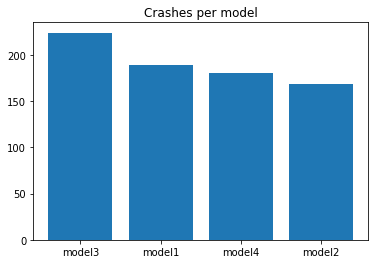

In [29]:
%matplotlib inline

import matplotlib.pyplot as plt
from rawapi import new_raw_client

raw = new_raw_client()

data = raw.query("""
    SELECT MODEL, COUNT(*) as crashes
        FROM machines m, failures f
        WHERE m.MACHINEID = f.machineID
        GROUP BY m.MODEL
        ORDER BY crashes DESC""")

data = list(data)

models = [r['MODEL'] for r in data]
crashes = [r['crashes'] for r in data]
plt.title('Crashes per model')
plt.bar(models,crashes)
plt.show()

Note that RAW’s Python client provides a smooth integration with Python. It produces Python iterators, dictionaries, etc. In some situations, RAW can even be generating data, server-side, in formats that can be efficiently processed in Python. Here is another example this time a scatter chart:

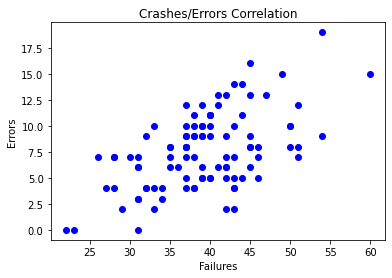

In [30]:
data = raw.query("""
    SELECT m.MACHINEID,
        SELECT COUNT(*) from failures f where m.MACHINEID = f.machineID as crashes,
        SELECT COUNT(*) from errors e where m.MACHINEID = e.machineID as errors    
    FROM machines m""")

data = list(data)

errors = [r['errors'] for r in data]
crashes = [r['crashes'] for r in data]

plt.title('Crashes/Errors Correlation')

plt.xlabel('Failures')
plt.ylabel('Errors')
plt.plot(errors, crashes, 'bo')
plt.show()

## Using an external tool (Tableau)

Thus far, we did queries and created views in the RAW Query Language.

RAW also provides a pure SQL compatibility layer: any view created in RAW that is a “SQL table” is automatically available through our SQL entry point. In the SQL entry point, users submitted ORACLE SQL dialect queries instead. The data sources are the “RQL views” that are SQL tables.

In fact, our Tableau integration uses the SQL compatibility layer and the JDBC driver. This allows business users to replicate the exact analysis shown above in a “no code” version. Here are some screenshots of the equivalent analysis:

|                               |                              |
| ----------------------------- |------------------------------|
| <img src="img/tableau6.png"/> |<img src="img/tableau3.png"/> |
| <img src="img/tableau5.png"/> |<img src="img/tableau2.png"/> |
